Karen Tatiana Zamudio Quintero

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [ ]:
!pip install contractions
import contractions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re  
import string

import multiprocessing
from gensim.models import Word2Vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Datos
Utilizaremos como dataset del guion de los simpsons en inglés extraido de https://www.kaggle.com/pierremegret, adicionalmente parte de este trabajo practico es basado del anterior link.

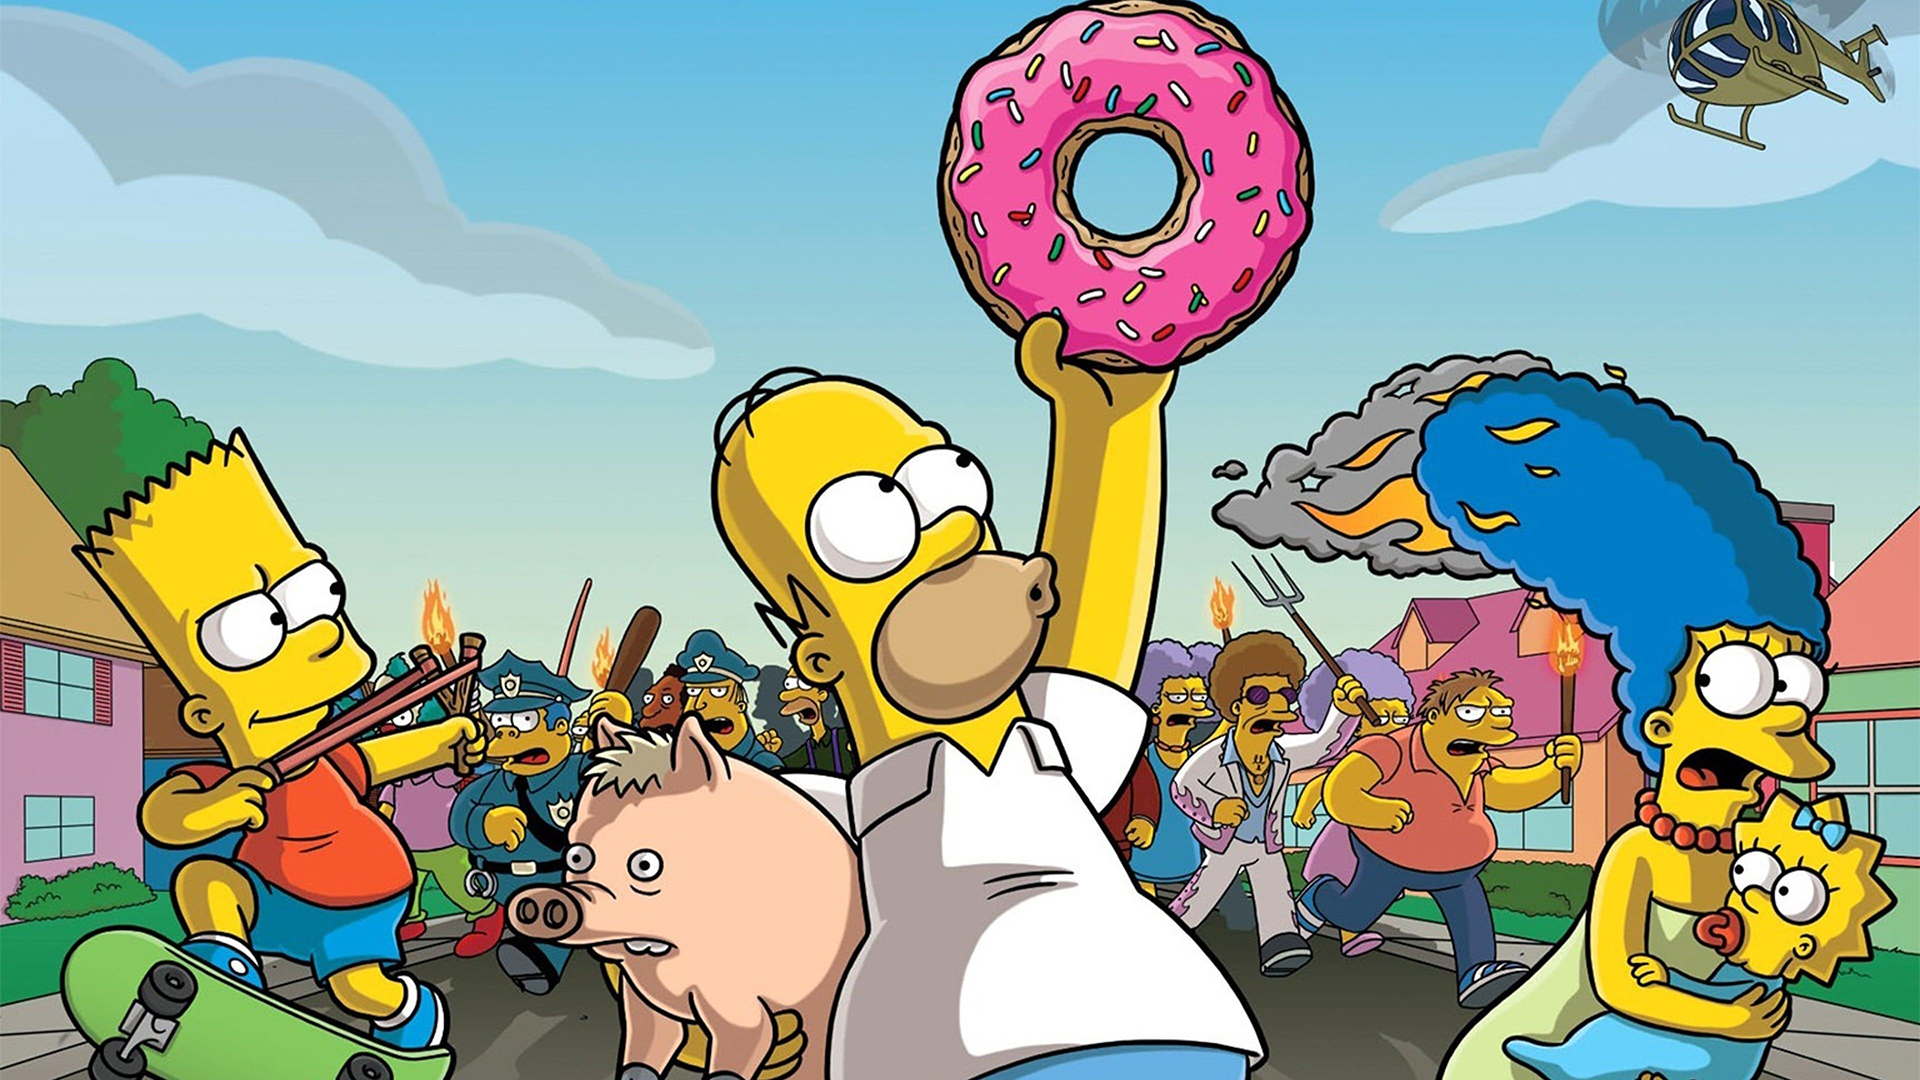

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('/content/simpsons_dataset.csv')
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
print(df['raw_character_text'].value_counts())

Homer Simpson            27850
Marge Simpson            13172
Bart Simpson             12995
Lisa Simpson             10756
C. Montgomery Burns       3077
                         ...  
Basketball Player            1
Oboist                       1
Father In Burlap Sack        1
Shelbyvillians               1
Voice From Diorama           1
Name: raw_character_text, Length: 6272, dtype: int64


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 158314


### 1 - Preprocesamiento

<figure>
<center>
<img src='https://i.pinimg.com/originals/7f/e7/d9/7fe7d9c7e40180b24aa1de38e7756707.gif'  width="" height="300"/>
</center>
</figure>

In [ ]:
#suma de valores nulos
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [ ]:
#remover valores nulos
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [ ]:
#eliminacion de contracciones del idioma ingles 
# Defino una funcion anonima que al pasarle un argumento devuelve el resultado de aplicarle la funcion anterior a este mismo argumento

def clean_text_round1(text):
    # pasa las mayusculas del texto a minusculas
    text = text.lower()                                              
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    text = re.sub('\[.*?¿\]\%', ' ', text)                           
    # reemplaza signos de puntuacion por espacio en blanco.. %s -> \S+ es cualquier caracter que no sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    # remueve palabras que contienen numeros.
    text = re.sub('\w*\d\w*', '', text)                              
    return text

def clean_text_round2(text):
    # Sacamos comillas, los puntos suspensivos, <<, >>
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text

round0 = lambda x: contractions.fix(x)
round1 = lambda x: clean_text_round1(x)
round2 = lambda x: clean_text_round2(x)

# Dataframe que resulta de aplicarle a las columnas la función de limpieza
df = pd.DataFrame(df.spoken_words.apply(round0))
df = pd.DataFrame(df.spoken_words.apply(round1))
df = pd.DataFrame(df.spoken_words.apply(round2))

In [ ]:
df['spoken_words']

0         no  actually  it was a little of both  sometim...
1                                   where is mr  bergstrom 
2         i do not know  although i would sure like to t...
3                                that life is worth living 
4         the polls will be open from now until the end ...
                                ...                        
131848                                           i am back 
131849    you see  class  my lyme disease turned out to ...
131850                                   psy cho so ma tic 
131851                       does that mean you were crazy 
131852                    no  that means she was faking it 
Name: spoken_words, Length: 131853, dtype: object

In [ ]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [ ]:
# Demos un vistazo
sentence_tokens[:2]

[['no',
  'actually',
  'it',
  'was',
  'a',
  'little',
  'of',
  'both',
  'sometimes',
  'when',
  'a',
  'disease',
  'is',
  'in',
  'all',
  'the',
  'magazines',
  'and',
  'all',
  'the',
  'news',
  'shows',
  'it',
  'is',
  'only',
  'natural',
  'that',
  'you',
  'think',
  'you',
  'have',
  'it'],
 ['where', 'is', 'mr', 'bergstrom']]

### 2 - Crear los vectores (word2vec)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=20,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300, # dimensionalidad de los vectores
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [ ]:
# Buildear el vocabularui con los tokens
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 131853


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 4113


### 3 - Entrenar el modelo generador

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 6386834.5
Loss after epoch 1: 5677572.5
Loss after epoch 2: 5518189.0
Loss after epoch 3: 5332762.0
Loss after epoch 4: 5305640.0
Loss after epoch 5: 5284112.0
Loss after epoch 6: 5627750.0
Loss after epoch 7: 5616056.0
Loss after epoch 8: 5595652.0
Loss after epoch 9: 5581540.0
Loss after epoch 10: 5578292.0
Loss after epoch 11: 5559824.0
Loss after epoch 12: 1148832.0
Loss after epoch 13: 1068024.0
Loss after epoch 14: 1030920.0
Loss after epoch 15: 986032.0
Loss after epoch 16: 947368.0
Loss after epoch 17: 905544.0
Loss after epoch 18: 867936.0
Loss after epoch 19: 833736.0


(17767148, 27837620)

### 4 - Ensayar

<figure>
<center>
<img src='https://i.pinimg.com/originals/b5/95/2b/b5952b40d6d79dcbc9d6ab9970db8ae2.gif'  width="800" height="500"/>
</center>
</figure>

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["bart"], topn=10)

[('lisa', 0.3323221504688263),
 ('homer', 0.3300219178199768),
 ('boy', 0.3289795517921448),
 ('nooooo', 0.3257787823677063),
 ('milhouse', 0.31179749965667725),
 ('you', 0.2926822900772095),
 ('arrrgh', 0.2885836660861969),
 ('zaius', 0.2872186303138733),
 ('i', 0.28475892543792725),
 ('mom', 0.2843146324157715)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["bart"], topn=10)

[('above', 0.08548000454902649),
 ('range', 0.0752587541937828),
 ('cabin', 0.06054402142763138),
 ('kick', 0.055187541991472244),
 ('firing', 0.05429408699274063),
 ('seats', 0.04714769497513771),
 ('square', 0.046319637447595596),
 ('newspapers', 0.042841073125600815),
 ('appears', 0.04275262728333473),
 ('chocolate', 0.04264974966645241)]

El coseno de similitud es una medida que compara la orientación de dos vectores en un espacio vectorial. En el caso de las incrustaciones de palabras en Gensim, los vectores representan la semántica y sintaxis de las palabras, por lo que calcular el coseno de similitud entre dos vectores de palabras te permite medir qué tan similares son en términos de su significado.

Un claro ejemplo de la relación positiva (mayor relación) con la palabra bart se visualiza en la linea de codigo 96, donde se evidencia que la palabra con mayor relacion es lisa. Por otro lado, la relación negativa (menor relación) con la palabra bart se visualiza en la linea de codigo 97, donde se evidencia que la palabra con menor relacion es *above*.

Es importante visualizar que cuando miramos la relación de la palabra lisa referente al dialogo en los capitulos de los simpson obtenemos los comentarios de otros personajes hacia esta. De esta manera no se obtienen, sus gustos o caracteristicas en primera persona, si no la subjetividad de otros hacia como persiven este personaje.

<figure>
<center>
<img src='https://media1.popsugar-assets.com/files/thumbor/ZJgNQbGJWHi1W53y2D4jNrXjjQY/fit-in/1024x1024/filters:format_auto-!!-:strip_icc-!!-/2017/04/26/922/n/1922283/a82fb6377c5c056d_tumblr_mmenwjiCSO1qh59n0o1_500/i/When-Someone-Says-You-Shouldnt-Hold-Grudge-Dont-Know-Youre-Holding-One-Against-Them-Currently.gif'  width="800" height="500"/>
</center>
</figure>

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["lisa"], topn=10)

[('homer', 0.34476447105407715),
 ('bart', 0.3323221206665039),
 ('honey', 0.3304181694984436),
 ('maggie', 0.3124041259288788),
 ('eliza', 0.31145456433296204),
 ('sweetie', 0.30273565649986267),
 ('delighted', 0.2947707176208496),
 ('marge', 0.29165053367614746),
 ('you', 0.2909018099308014),
 ('janey', 0.28544461727142334)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["lisa"], topn=10)

[('furniture', 0.08532402664422989),
 ('land', 0.07833968847990036),
 ('mornin', 0.06906477361917496),
 ('dive', 0.061309851706027985),
 ('trained', 0.06052255630493164),
 ('testing', 0.060185499489307404),
 ('river', 0.05519181117415428),
 ('bury', 0.05373881012201309),
 ('walls', 0.05315525084733963),
 ('lifetime', 0.05281195044517517)]


<figure>
<center>
<img src='https://thumbs.gfycat.com/DirectImperturbableHyrax-size_restricted.gif'  width="800" height="500"/>
</center>
</figure>

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["homer"], topn=10)

[('marge', 0.41132697463035583),
 ('simpson', 0.38207530975341797),
 ('arrrgh', 0.34658482670783997),
 ('lisa', 0.34476447105407715),
 ('nooooo', 0.3367752432823181),
 ('homie', 0.33562371134757996),
 ('dad', 0.33175602555274963),
 ('abe', 0.33152419328689575),
 ('bart', 0.3300219476222992),
 ('moe', 0.32934433221817017)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(negative=["homer"], topn=10)

[('using', 0.11656603962182999),
 ('uses', 0.09553726017475128),
 ('massage', 0.05906736105680466),
 ('farewell', 0.05615905299782753),
 ('mint', 0.04884577915072441),
 ('ages', 0.04875459522008896),
 ('clue', 0.047439299523830414),
 ('hulk', 0.04550103098154068),
 ('miserable', 0.044035740196704865),
 ('fingers', 0.04172135144472122)]

<figure>
<center>
<img src='https://media.tenor.com/HC5czhxIYsgAAAAC/mr-burns-excellent.gif'  width="800" height="500"/>
</center>
</figure>

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["excellent"], topn=10)

[('fifteen', 0.26894357800483704),
 ('versus', 0.2561734616756439),
 ('ling', 0.25437507033348083),
 ('oo', 0.24909785389900208),
 ('easier', 0.24871958792209625),
 ('ay', 0.24666957557201385),
 ('impressive', 0.2441413849592209),
 ('accepted', 0.2426581084728241),
 ('exercise', 0.24245484173297882),
 ('speech', 0.24243997037410736)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["excellent"], topn=10)

[('wins', 0.12152455002069473),
 ('bet', 0.12035735696554184),
 ('bowl', 0.11273687332868576),
 ('celebrities', 0.09489136189222336),
 ('slice', 0.09248102456331253),
 ('strip', 0.08621581643819809),
 ('road', 0.08614981919527054),
 ('mighty', 0.08401891589164734),
 ('loves', 0.0806083008646965),
 ('poop', 0.08024988323450089)]

In [ ]:
#calcular la similitud semantica entre pares de palabras individuales 
print("similitud entre lisa y bart", w2v_model.wv.similarity("bart", 'lisa'))
print("similitud entre lisa y marge", w2v_model.wv.similarity("marge",'lisa'))
print("similitud entre lisa y homer", w2v_model.wv.similarity("homer",'lisa'))
print("similitud entre lisa y milhouse", w2v_model.wv.similarity("milhouse",'lisa'))
print("similitud entre lisa y maggie", w2v_model.wv.similarity("maggie",'lisa'))

similitud entre lisa y bart 0.33232212
similitud entre lisa y marge 0.29165056
similitud entre lisa y homer 0.3447645
similitud entre lisa y milhouse 0.24064846
similitud entre lisa y maggie 0.31240407


In [ ]:
#calcular la similitud semantica entre pares de palabras individuales 
print("similitud entre bart y lisa", w2v_model.wv.similarity("lisa", 'bart'))
print("similitud entre bart y marge", w2v_model.wv.similarity("marge",'bart'))
print("similitud entre bart y homer", w2v_model.wv.similarity("homer",'bart'))
print("similitud entre bart y milhouse", w2v_model.wv.similarity("milhouse",'bart'))


similitud entre bart y lisa 0.33232212
similitud entre bart y marge 0.24950613
similitud entre bart y homer 0.33002195
similitud entre bart y milhouse 0.31179756


In [ ]:
#calcular la similitud semantica entre pares de palabras individuales 
print("similitud entre marge y bart", w2v_model.wv.similarity("bart", 'marge'))
print("similitud entre marge y lisa", w2v_model.wv.similarity("lisa",'marge'))
print("similitud entre marge y homer", w2v_model.wv.similarity("homer",'marge'))

similitud entre marge y bart 0.24950613
similitud entre marge y lisa 0.29165056
similitud entre marge y homer 0.411327


In [ ]:
#calcular qué palabra de la lista dada, no va con las otras

print("Qué palabra 'lisa', 'milhouse', 'bart' no va con las otras :", w2v_model.wv.doesnt_match(['lisa', 'milhouse', 'bart']))
print("Qué palabra 'cherry', 'celebrity', 'bum' no va con las otras :", w2v_model.wv.doesnt_match(['cherry', 'celebrity', 'bum']))

Qué palabra 'lisa', 'milhouse', 'bart' no va con las otras : milhouse
Qué palabra 'cherry', 'celebrity', 'bum' no va con las otras : celebrity


In [ ]:
w2v_model.wv.doesnt_match(['lisa', 'milhouse', 'bart'])

'milhouse'

In [ ]:
#¿Qué es a "Mujer" lo que Bart es a "Hombre"? ¿Y lo mismo pero con Homero en vez de Bart?
print(w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3))
print(w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["man"], topn=3))

[('means', 0.2845137119293213), ('bender', 0.28373485803604126), ('chalmers', 0.2746419906616211)]
[('homie', 0.31077900528907776), ('wife', 0.27987897396087646), ('lurleen', 0.27488961815834045)]


### 5 - Visualizar agrupación de vectores

In [ ]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  #index2word

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [ ]:
# se implementa función para graficar los embedddings en 2D, extraida de https://towardsdatascience.com/how-to-train-a-word2vec-model-from-scratch-with-gensim-c457d587e031
def plot_embeddings(x_vals, y_vals, labels):
    import plotly.graph_objs as go
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Word2Vec - Visualizzazione embedding con TSNE")
    fig.show()
    return fig

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

plot = plot_embeddings(x_vals, y_vals, labels)

*Gensim* es una biblioteca de Python utilizada para el procesamiento de lenguaje natural (NLP). Custom embeddings (incrustaciones personalizadas) en Gensim se refiere a la capacidad de entrenar y utilizar vectores de palabras personalizados en lugar de utilizar incrustaciones pre-entrenadas.

De esta manera, se entiende que se puede entrenar tus propias incrustaciones de palabras utilizando técnicas como Word2Vec implementada en el presente trabajo práctico. Estos algoritmos de incrustación de palabras permiten representar palabras en forma de vectores numéricos en un espacio vectorial de alta dimensión. Estos vectores capturan información semántica y sintáctica de las palabras y se pueden usar para diversas tareas de procesamiento de lenguaje natural, como clasificación de texto, agrupación de documentos, búsqueda de similitudes semánticas, entre otros.

*Gensim* permite entrenar tus propias incrustaciones personalizadas de palabras para capturar la semántica y sintaxis específica de tu corpus de datos, lo cual puede ser beneficioso en varios escenarios, como cuando trabajas con datos específicos de dominio como se visualiza en el presente trabajo practico a traves del dialogo de los simpson. para lo anterior, se hace necesario tener en cuenta que el entrenamiento de incrustaciones personalizadas requiere un corpus de datos adecuado y puede requerir tiempo y recursos computacionales, pero puede mejorar la precisión y el rendimiento de tu modelo en tareas de procesamiento de lenguaje natural.

### Alumno

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.